In [1]:
import cv2 as cv
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import pickle
from keras_facenet import FaceNet
import matplotlib.pyplot as plt
from mtcnn.mtcnn import MTCNN
import time

# detector: MTCNN

1/1 [==============================] - 2s 2s/step


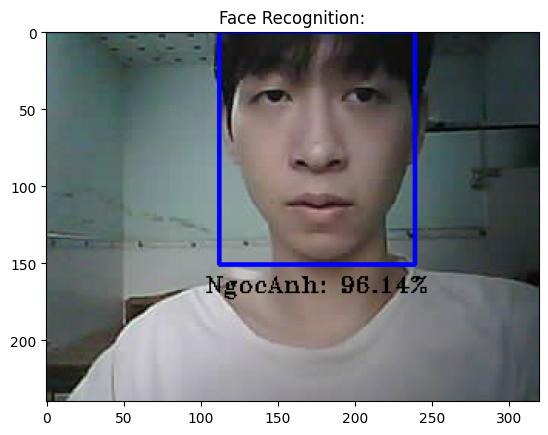

MTCNN detection time: 8.21 seconds


In [2]:
start_time = time.time()
facenet = FaceNet()
current_path = os.getcwd().replace("\\", "/")
faces_embeddings = np.load(current_path + "/faces_embeddings_done_4classes.npz")
Y = faces_embeddings['arr_1']
encoder = LabelEncoder()
encoder.fit(Y)
detector = MTCNN()
model = pickle.load(open(current_path + "/svm_model_160x160.pkl", 'rb'))
# Load image
img = cv.imread("./test_img/z4311355377660_d5c60c6533d07a6587363ffa3563f78f.jpg")
# img = cv.imread("./test_img/NguyenAnh_test.jpg")
rgb_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
# Detect faces
faces = detector.detect_faces(rgb_img)
if len(faces) == 0:
    final_name = "unknown"
    text = "{}".format(final_name)
    font = cv.FONT_HERSHEY_TRIPLEX
    font_scale = 0.5
    thickness = 1
    # Get the size of the text
    (text_width, text_height), _ = cv.getTextSize(text, font, font_scale, thickness)
    # Adjust the position of the text based on the size of the image
    text_x = int(rgb_img.shape[1] / 2 - text_width / 2)
    text_y = int(rgb_img.shape[0] / 2 - text_height / 2)
    # Draw the text
    cv.putText(rgb_img, text, (text_x, text_y), font, font_scale, (0, 0, 0), thickness)
else: 
    for face in faces:
        x, y, w, h = face['box']
        keypoints = face['keypoints']
        # Extract face from image and preprocess for facenet
        img_face = rgb_img[y:y+h, x:x+w]
        img_face = cv.resize(img_face, (160,160))
        img_face = np.expand_dims(img_face, axis=0)
        # img_face = preprocess_input(img_face)
        # Generate embeddings using facenet
        embeddings = facenet.embeddings(img_face)
        # Predict label and probability using SVM
        face_prob = model.predict_proba(embeddings)
        max_prob = np.max(face_prob)
        if max_prob < 0.75:
            final_name = "unknown"
            text = "{}: {:.2f}%".format(final_name, max_prob*100)
        else:
            face_name = model.predict(embeddings)
            final_name = encoder.inverse_transform(face_name)[0]
            text = "{}: {:.2f}%".format(final_name, max_prob*100)
        # Draw bounding box and label on image
        font = cv.FONT_HERSHEY_TRIPLEX
        font_scale = 0.5
        thickness = 1
        # Get the size of the text
        (text_width, text_height), _ = cv.getTextSize(text, font, font_scale, thickness)
        # Adjust the position of the text based on the size of the bounding box
        text_x = x + int((w - text_width) / 2)
        text_y = y + h + int(text_height * 1.5)
        # Draw the bounding box and text
        cv.rectangle(rgb_img, (x, y), (x+w, y+h), (0, 0, 255), 2)
        cv.putText(rgb_img, text, (text_x, text_y), font, font_scale, (0, 0, 0), thickness)
# Display result
if img is not None and len(img.shape) > 0 and img.shape[0] > 0 and img.shape[1] > 0:
    rgb_img = cv.cvtColor(rgb_img, cv.COLOR_BGR2RGB)
    plt.imshow(rgb_img[...,::-1])
    plt.title("Face Recognition:")
    plt.show()
else:
    print("Invalid image shape")
end_time = time.time()
print("MTCNN detection time: {:.2f} seconds".format(end_time - start_time))


# detector: haarcascade

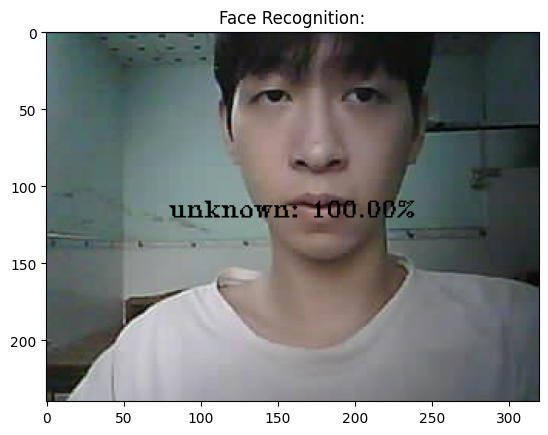

haarcascade detection time: 1.83 seconds


In [3]:
start_time = time.time()
img = cv.imread("./test_img/z4311355377660_d5c60c6533d07a6587363ffa3563f78f.jpg")
# img = cv.imread("./test_img/NguyenAnh_test.jpg")
rgb_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
detector = cv.CascadeClassifier(current_path + "/haarcascade_frontalface_default.xml")
faces = detector.detectMultiScale(gray_img, 1.3, 5)
if len(faces) == 0:
    final_name = "unknown"
    text = "{}: {:.2f}%".format(final_name, 100)
    # Draw text on image
    font = cv.FONT_HERSHEY_TRIPLEX
    font_scale = 0.5
    thickness = 1
    text_width, text_height = cv.getTextSize(text, font, font_scale, thickness)[0]
    text_x = int((rgb_img.shape[1] - text_width) / 2)
    text_y = int(rgb_img.shape[0] / 2)
    cv.putText(rgb_img, text, (text_x, text_y), font, font_scale, (0, 0, 0), thickness)
else:
    for x, y, w, h in faces:
        img_face = rgb_img[y:y + h, x:x + w]
        img_face = cv.resize(img_face, (160, 160))  # 1x160x160x3
        img_face = np.expand_dims(img_face, axis=0)
        ypred = facenet.embeddings(img_face)
        face_prob = model.predict_proba(ypred)
        max_prob = np.max(face_prob)
        if max_prob < 0.75:
            final_name = "unknown"
            text = "{}: {:.2f}%".format(final_name, max_prob * 100)
        else:
            face_name = model.predict(ypred)
            final_name = encoder.inverse_transform(face_name)[0]
            text = "{}: {:.2f}%".format(final_name, max_prob * 100)
        # Draw bounding box and label on image
        font = cv.FONT_HERSHEY_TRIPLEX
        font_scale = 0.5
        thickness = 1
        # Get the size of the text
        (text_width, text_height), _ = cv.getTextSize(text, font, font_scale, thickness)
        # Adjust the position of the text based on the size of the bounding box
        text_x = x + int((w - text_width) / 2)
        text_y = y + h + int(text_height * 1.5)
        # Draw the bounding box and text
        cv.rectangle(rgb_img, (x, y), (x + w, y + h), (0, 0, 255), 2)
        cv.putText(rgb_img, text, (text_x, text_y), font, font_scale, (0, 0, 0), thickness)
if img is not None and len(img.shape) > 0 and img.shape[0] > 0 and img.shape[1] > 0:
    rgb_img = cv.cvtColor(rgb_img, cv.COLOR_BGR2RGB)
    plt.imshow(rgb_img[...,::-1])
    plt.title("Face Recognition:")
    plt.show()
else:
    print("Invalid image shape")

end_time = time.time()
print("haarcascade detection time: {:.2f} seconds".format(end_time - start_time))


1/1 [==============================] - 2s 2s/step


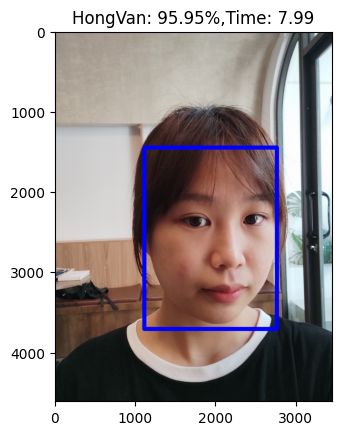

In [16]:
facenet = FaceNet()
current_path = os.getcwd().replace("\\", "/")
faces_embeddings = np.load(current_path + "/faces_embeddings_done_4classes.npz")
Y = faces_embeddings['arr_1']
encoder = LabelEncoder()
encoder.fit(Y)
detector = MTCNN()
model = pickle.load(open(current_path + "/svm_model_160x160.pkl", 'rb'))
# Load image
img = cv.imread("./dataset/test/HongVan/IMG_20230527_142154.jpg")
# img = cv.imread("./test_img/NguyenAnh_test.jpg")
rgb_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
# Detect faces
start_time = time.time()
faces = detector.detect_faces(rgb_img)
if len(faces) == 0:
    final_name = "unknown"
    end_time = time.time()
    text = "{}, Time: {:.2f}".format(final_name, (end_time - start_time))
else: 
    for face in faces:
        x, y, w, h = face['box']
        keypoints = face['keypoints']
        # Extract face from image and preprocess for facenet
        img_face = rgb_img[y:y+h, x:x+w]
        img_face = cv.resize(img_face, (160,160))
        img_face = np.expand_dims(img_face, axis=0)
        # img_face = preprocess_input(img_face)
        # Generate embeddings using facenet
        embeddings = facenet.embeddings(img_face)
        # Predict label and probability using SVM
        face_prob = model.predict_proba(embeddings)
        max_prob = np.max(face_prob)
        if max_prob < 0.75:
            final_name = "unknown"
            end_time = time.time()
            text = "{}: {:.2f}%,Time: {:.2f}".format(final_name, max_prob*100, (end_time - start_time))
        else:
            face_name = model.predict(embeddings)
            final_name = encoder.inverse_transform(face_name)[0]
            end_time = time.time()
            text = "{}: {:.2f}%,Time: {:.2f}".format(final_name, max_prob*100, (end_time - start_time))
        # Draw the bounding box and text
        cv.rectangle(rgb_img, (x, y), (x+w, y+h), (0, 0, 255), 50)
        # cv.putText(rgb_img, text, (x, y-30), cv.FONT_HERSHEY_SIMPLEX, 2, (0,0,0), 3)
        

# Display result
if img is not None and len(img.shape) > 0 and img.shape[0] > 0 and img.shape[1] > 0:
    rgb_img = cv.cvtColor(rgb_img, cv.COLOR_BGR2RGB)
    plt.imshow(rgb_img[...,::-1])
    plt.title(text)
    plt.show()
else:
    print("Invalid image shape")